### Due to computational limitations from google colab, we illustrate the training and testing of a network on CMC maps using a simplify version of the benchmark codes and also using a fraction of all the data available. We note that the results obtained in this example are far from optimal and are just shown as an illustration.

### Import libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import time, sys, os
import matplotlib.pyplot as plt
import optuna
from sklearn.metrics import r2_score
from tqdm import tqdm

from models import model_o3_err, model_o3_err_cosmology, model_o3_err_18layers
from dataloader import create_dataset_multifield

In [2]:
# import CKA package
# from similarity.CKA import CKA, CudaCKA
# from absl import flags
from similarity.efficient_CKA import *

2023-11-12 10:36:08.678001: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-12 10:36:09.326944: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### The code will run on both CPUs or GPUs

In [3]:
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')
cudnn.benchmark = True      #May train faster but cost more memory

CUDA Available


### Define the value of the parameters and hyperparameters

In [4]:
# data parameters
fmaps      = ['maps_T.npy'] #tuple containing the maps with the different fields to consider
fmaps_norm = [None] #if you want to normalize the maps according to the properties of some data set, put that data set here (This is mostly used when training on IllustrisTNG and testing on SIMBA, or vicerversa)
seed       = 1   #random seed to split maps among training, validation and testing
splits     = 15   #number of maps per simulation

# training parameters
channels        = 1                #we only consider here 1 field
# params          = [0,1,2,3,4,5]    #0(Omega_m) 1(sigma_8) 2(A_SN1) 3 (A_AGN1) 4(A_SN2) 5(A_AGN2). The code will be trained to predict all these parameters.
params          = [0,1]
g               = params           #g will contain the mean of the posterior
# h               = [6+i for i in g] #h will contain the variance of the posterior
h               = [2+i for i in g]
rot_flip_in_mem = True             #whether rotations and flipings are kept in memory. True will make the code faster but consumes more RAM memory.

# optimizer parameters
beta1 = 0.5
beta2 = 0.999

# hyperparameters
batch_size = 128
min_lr     = 1e-9
max_lr     = 0.0036  # default: 1e-3
wd         = 0.0258  #value of weight decay, default: 0.0005
dr         = 0.4     #dropout value for fully connected layers, default: 0.2
hidden     = 11       #this determines the number of channels in the CNNs; integer larger than 1, default: 5
epochs     = 50      #number of epochs to train the network

# output files names
floss  = 'loss.txt'   #file with the training and validation losses for each epoch
fmodel = 'weights.pt' #file containing the weights of the best-model

In [5]:
# TNG - 43

# data
fparams = '2D_maps/data/params_LH_IllustrisTNG.txt'
fmaps2 = '2D_maps/data/Maps_T_IllustrisTNG_LH_z=0.00.npy'

maps  = np.load(fmaps2)
np.save('maps_T_TNG.npy', maps)
print('Shape of the maps:', maps.shape)
del maps

Shape of the maps: (15000, 256, 256)


In [6]:
# SIMBA - 37

# data
fparams = '2D_maps/data/params_LH_SIMBA.txt'
fmaps2 = '2D_maps/data/Maps_T_SIMBA_LH_z=0.00.npy'

maps  = np.load(fmaps2)
np.save('maps_T_SIMBA.npy', maps)
print('Shape of the maps:', maps.shape)
del maps

Shape of the maps: (15000, 256, 256)


In [7]:
# TNG + SIMBA

# data
fmaps2_TNG = '2D_maps/data/Maps_T_IllustrisTNG_LH_z=0.00.npy'
fmaps2_SIMBA = '2D_maps/data/Maps_T_SIMBA_LH_z=0.00.npy'

fparams = '2D_maps/data/params_LH.txt'

# load data
maps_TNG = np.load(fmaps2_TNG)
maps_SIMBA = np.load(fmaps2_SIMBA)
maps = np.concatenate((maps_TNG, maps_SIMBA), axis=0)
np.save('maps_T.npy', maps)
print('Shape of the maps:', maps.shape)
del maps

Shape of the maps: (30000, 256, 256)


### These routines define the way the data is input and fed into the network. We then read the data and get the training and validation sets

In [8]:
# # get training set
# print('\nPreparing training set')
# train_loader = create_dataset_multifield('train', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
#                                          rot_flip_in_mem=rot_flip_in_mem, verbose=True)

# # get validation set
# print('\nPreparing validation set')
# valid_loader = create_dataset_multifield('valid', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
#                                          rot_flip_in_mem=True,  verbose=True)

### Define the model architecture and use it.




### Now test the model

In [9]:
# now that architecture is defined above, use it
model = model_o3_err_cosmology(hidden, dr, channels)
# model = nn.DataParallel(model)
model.to(device=device)
network_total_params = sum(p.numel() for p in model.parameters())
print('total number of parameters in the model = %d'%network_total_params)

# load the weights in case they exists
# fmodel = 'layer17_TNG/weights.pt'
fmodel = 'layer20_TNG_SIMBA/weights.pt'
# fmodel = 'best_weights_T_TNG.pt'

if os.path.exists(fmodel):
    checkpoint = torch.load(fmodel, map_location=torch.device(device))
    new_state_dict = {k.replace('module.', ''): v for k, v in checkpoint.items()}
    model.load_state_dict(new_state_dict)
    
    # model.load_state_dict(torch.load(fmodel, map_location=torch.device(device)))
    print('Weights loaded')

total number of parameters in the model = 28430736
Weights loaded


In [53]:
# now that architecture is defined above, use it
model = model_o3_err(hidden, dr, channels)
# model = nn.DataParallel(model)
model.to(device=device)
network_total_params = sum(p.numel() for p in model.parameters())
print('total number of parameters in the model = %d'%network_total_params)

# load the weights in case they exists
# fmodel = 'layer17_TNG/weights.pt'
# fmodel = 'layer20_TNG_SIMBA/weights.pt'
fmodel = 'best_weights_T_TNG.pt'

if os.path.exists(fmodel):
    checkpoint = torch.load(fmodel, map_location=torch.device(device))
    new_state_dict = {k.replace('module.', ''): v for k, v in checkpoint.items()}
    model.load_state_dict(new_state_dict)
    
    # model.load_state_dict(torch.load(fmodel, map_location=torch.device(device)))
    print('Weights loaded')

total number of parameters in the model = 28436376
Weights loaded


In [44]:
# now that architecture is defined above, use it
model = model_o3_err_18layers(hidden, dr, channels)
# model = nn.DataParallel(model)
model.to(device=device)
network_total_params = sum(p.numel() for p in model.parameters())
print('total number of parameters in the model = %d'%network_total_params)

# load the weights in case they exists
fmodel = 'layer17_TNG/weights.pt'
# fmodel = 'layer20_TNG_SIMBA/weights.pt'
# fmodel = 'best_weights_T_TNG.pt'

if os.path.exists(fmodel):
    checkpoint = torch.load(fmodel, map_location=torch.device(device))
    new_state_dict = {k.replace('module.', ''): v for k, v in checkpoint.items()}
    model.load_state_dict(new_state_dict)
    
    # model.load_state_dict(torch.load(fmodel, map_location=torch.device(device)))
    print('Weights loaded')

total number of parameters in the model = 8851096
Weights loaded


In [6]:
# load test set
fmaps = ['maps_T.npy']
fparams = '2D_maps/data/params_LH.txt'
test_loader  = create_dataset_multifield('test', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                                         rot_flip_in_mem=False, verbose=True, simulation='SIMBA')

SIMBA: 54
810
Found 1 channels
Reading data...
2.215e+02 < F(all|orig) < 2.772e+11
2.345 < F(all|resc)  < 11.443
-2.068 < F(all|norm) < 5.235


In [43]:
# load test set
fmaps = ['maps_T_TNG.npy']
fparams = '2D_maps/data/params_LH_IllustrisTNG.txt'
test_loader  = create_dataset_multifield('test', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                                         rot_flip_in_mem=False, verbose=True)

750
Found 1 channels
Reading data...
1.502e+03 < F(all|orig) < 8.669e+07
3.177 < F(all|resc)  < 7.938
-1.282 < F(all|norm) < 4.550


In [51]:
# load test set
fmaps = ['maps_T_SIMBA.npy']
fparams = '2D_maps/data/params_LH_SIMBA.txt'
test_loader  = create_dataset_multifield('test', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                                         rot_flip_in_mem=False, verbose=True)

750


Found 1 channels
Reading data...
2.215e+02 < F(all|orig) < 2.772e+11
2.345 < F(all|resc)  < 11.443
-2.708 < F(all|norm) < 4.815


In [10]:
# get the number of maps in the test set
num_maps = 0
for x,y in test_loader:
      num_maps += x.shape[0]
print('\nNumber of maps in the test set: %d'%num_maps)

# define the arrays containing the value of the parameters
params_true = np.zeros((num_maps,len(g)), dtype=np.float32)
params_NN   = np.zeros((num_maps,len(g)), dtype=np.float32)
errors_NN   = np.zeros((num_maps,len(g)), dtype=np.float32)

# get test loss
test_loss1, test_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
test_loss, points = 0.0, 0
model.eval()
for x, y in test_loader:
    with torch.no_grad():
        bs    = x.shape[0]    #batch size
        x     = x.to(device)  #send data to device
        y     = y.to(device)[:,g]  #send data to device
        p     = model(x)      #prediction for mean and variance
        y_NN  = p[:,g]       #prediction for mean
        e_NN  = p[:,h]       #prediction for error
        loss1 = torch.mean((y_NN[:,g] - y[:,g])**2,                     axis=0)
        loss2 = torch.mean(((y_NN[:,g] - y[:,g])**2 - e_NN[:,g]**2)**2, axis=0)
        test_loss1 += loss1*bs
        test_loss2 += loss2*bs

        # save results to their corresponding arrays
        params_true[points:points+x.shape[0]] = y.cpu().numpy()
        params_NN[points:points+x.shape[0]]   = y_NN.cpu().numpy()
        errors_NN[points:points+x.shape[0]]   = e_NN.cpu().numpy()
        points    += x.shape[0]
test_loss = torch.log(test_loss1/points) + torch.log(test_loss2/points)
test_loss = torch.mean(test_loss).item()
print('Test loss = %.3e\n'%test_loss)

Norm_error = np.sqrt(np.mean((params_true - params_NN)**2, axis=0))
print('Normalized Error Omega_m = %.3f'%Norm_error[0])
print('Normalized Error sigma_8 = %.3f'%Norm_error[1])
# print('Normalized Error A_SN1   = %.3f'%Norm_error[2])
# print('Normalized Error A_AGN1  = %.3f'%Norm_error[3])
# print('Normalized Error A_SN2   = %.3f'%Norm_error[4])
# print('Normalized Error A_AGN2  = %.3f\n'%Norm_error[5])

# de-normalize
# minimum = np.array([0.1, 0.6, 0.25, 0.25, 0.5, 0.5])
# maximum = np.array([0.5, 1.0, 4.00, 4.00, 2.0, 2.0])
minimum = np.array([0.1, 0.6])
maximum = np.array([0.5, 1.0])
params_true = params_true*(maximum - minimum) + minimum
params_NN   = params_NN*(maximum - minimum) + minimum
errors_NN   = errors_NN*(maximum - minimum)

error = np.sqrt(np.mean((params_true - params_NN)**2, axis=0))
print('Error Omega_m = %.3f'%error[0])
print('Error sigma_8 = %.3f'%error[1])
# print('Error A_SN1   = %.3f'%error[2])
# print('Error A_AGN1  = %.3f'%error[3])
# print('Error A_SN2   = %.3f'%error[4])
# print('Error A_AGN2  = %.3f\n'%error[5])

mean_error = np.absolute(np.mean(errors_NN, axis=0))
print('Bayesian error Omega_m = %.3f'%mean_error[0])
print('Bayesian error sigma_8 = %.3f'%mean_error[1])
# print('Bayesian error A_SN1   = %.3f'%mean_error[2])
# print('Bayesian error A_AGN1  = %.3f'%mean_error[3])
# print('Bayesian error A_SN2   = %.3f'%mean_error[4])
# print('Bayesian error A_AGN2  = %.3f\n'%mean_error[5])

rel_error = np.sqrt(np.mean((params_true - params_NN)**2/params_true**2, axis=0))
print('Relative error Omega_m = %.3f'%rel_error[0])
print('Relative error sigma_8 = %.3f'%rel_error[1])
# print('Relative error A_SN1   = %.3f'%rel_error[2])
# print('Relative error A_AGN1  = %.3f'%rel_error[3])
# print('Relative error A_SN2   = %.3f'%rel_error[4])
# print('Relative error A_AGN2  = %.3f\n'%rel_error[5])

# save results to file
#dataset = np.zeros((num_maps,18), dtype=np.float32)
#dataset[:,:6]   = params_true
#dataset[:,6:12] = params_NN
#dataset[:,12:]  = errors_NN
#np.savetxt(fresults,  dataset)
#np.savetxt(fresults1, Norm_error)


Number of maps in the test set: 810
Test loss = -1.184e+01

Normalized Error Omega_m = 0.065
Normalized Error sigma_8 = 0.144
Error Omega_m = 0.026
Error sigma_8 = 0.058
Bayesian error Omega_m = 0.026
Bayesian error sigma_8 = 0.145
Relative error Omega_m = 0.084
Relative error sigma_8 = 0.070


## compute CKA similarity

In [74]:
def normalize_activations(act):
    """Normalize along each row so that the norm of activations produced by each example is 1."""
    act = act.view(act.size(0), -1)
    act_norm = torch.linalg.norm(act, dim=1, keepdim=True)
    act /= act_norm
    return act

def get_activations(images, model, normalize_act=False):
    """Return a list of activations obtained from a model on a set of images."""
    activations = []

    def hook_fn(module, input, output):
        if normalize_act:
            output = normalize_activations(output)
        activations.append(output)

    hooks = []
    for layer in model.children():
        if 'Linear' in str(layer) or 'Conv2d' in str(layer):
            hooks.append(layer.register_forward_hook(hook_fn))

    with torch.no_grad():
        model(images)

    for hook in hooks:
        hook.remove()

    return activations

# Plotting the heatmap with 'magma' colormap and flipping the matrix vertically
def plotHeatmap(heatmap, modelName):
    # plt.imshow(np.flipud(heatmap), cmap='magma', interpolation='nearest')
    imshowobj = plt.imshow(np.flipud(heatmap), cmap='magma', interpolation='nearest')
    # imshowobj.set_clim(0,1)
    plt.colorbar()
    plt.title('CKA$_{minibatch}$'+f' - {modelName}', fontsize=20)
    plt.xlabel('Layer', fontsize=20)
    plt.ylabel('Layer', fontsize=20)
    plt.xticks(ticks=np.arange(1, heatmap.shape[1], 2), labels=[f"{i+1}" for i in range(1, heatmap.shape[1], 2)], fontsize=12)
    plt.yticks(ticks=np.arange(0, heatmap.shape[0], 2), labels=[f"{i+1}" for i in range(heatmap.shape[0]-1, -1, -2)], fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.savefig(f"heatmap/Heatmap_{modelName}.png", dpi=300)
    # files.download(f"Heatmap_{modelName}.png")
    plt.show()

In [79]:
model = model.to('cpu')
model.eval()
# n_layers = len(model.layers)
n_layers = 21
cka = MinibatchCKA(n_layers)
count = 0
iteration = 10
for i in tqdm(range(iteration)):
    for data, target in tqdm(test_loader):
        act = get_activations(data, model, False)
        # print(len(act))
        cka.update_state(act)
        # print(len(data))
        count += len(data)

100%|██████████| 10/10 [04:09<00:00, 24.99s/it]


In [80]:
heatmap = cka.result().numpy()
# eigenvalues, eigenvectors = np.linalg.eig(heatmap)
np.save("heatmap/Layer21_SIMBA(TNG+SIMBA).npy", heatmap)

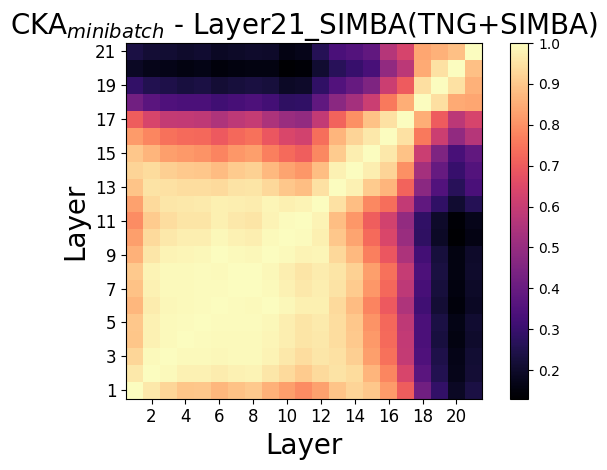

In [81]:
name = 'Layer21_SIMBA(TNG+SIMBA)'
heatmap = np.load("heatmap/{}.npy".format(name))
plotHeatmap(heatmap, '{}'.format(name)) # accuracy 99.12%

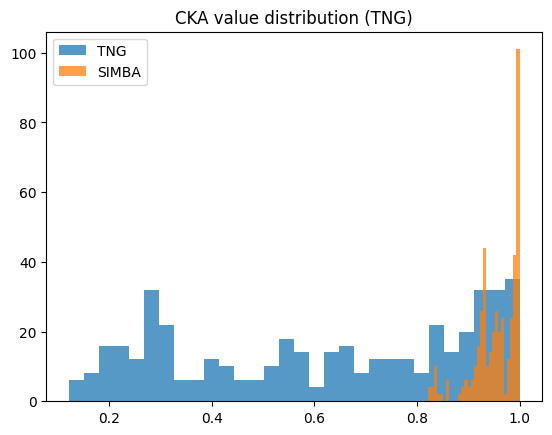

In [83]:
heatmap_TNG = np.load("heatmap/Layer21_TNG.npy")
heatmap_SIMBA = np.load("heatmap/Layer21_SIMBA.npy")
plt.hist(heatmap_TNG.flatten(), bins=30, label='TNG', alpha=0.75)
plt.hist(heatmap_SIMBA.flatten(), bins=30, label='SIMBA', alpha=0.75)
plt.legend()
plt.title('CKA value distribution (TNG)')
plt.savefig('figures/dist_CKA_T.png')
plt.show()

In [28]:
e_SIMBA_TNG_18 = eigenvalues

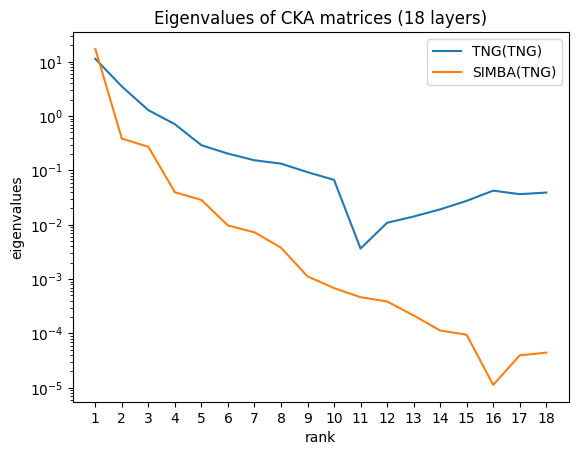

In [32]:
x = list(range(1, 19))
plt.plot(x, e_TNG_TNG_18, label='TNG(TNG)')
plt.plot(x, e_SIMBA_TNG_18, label='SIMBA(TNG)')
plt.legend()
plt.yscale('log')
plt.xticks(x, list(range(1, 19)))
plt.xlabel('rank')
plt.ylabel('eigenvalues')
plt.title('Eigenvalues of CKA matrices (18 layers)')
plt.savefig('eigenvalue_18layers.png')
plt.show()


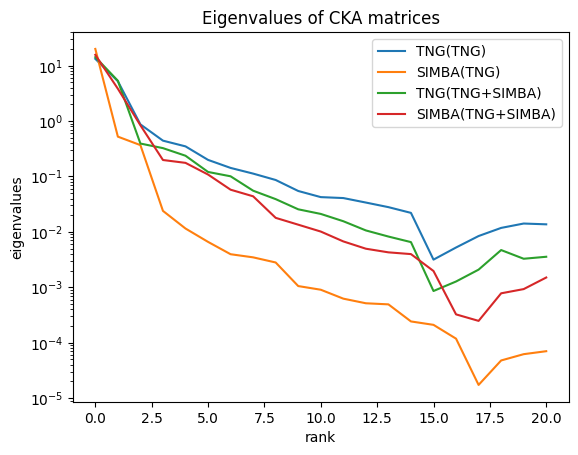

In [50]:
plt.plot(e_TNG_TNG, label='TNG(TNG)')
plt.plot(e_SIMBA_TNG, label='SIMBA(TNG)')
plt.plot(e_TNG_all, label='TNG(TNG+SIMBA)')
plt.plot(e_SIMBA_all, label='SIMBA(TNG+SIMBA)')
plt.legend()
plt.yscale('log')
plt.xlabel('rank')
plt.ylabel('eigenvalues')
plt.title('Eigenvalues of CKA matrices')
plt.savefig('eigenvalue.png')
plt.show()

## Across model CKA similarity

In [10]:
def normalize_activations(act):
    """Normalize along each row so that the norm of activations produced by each example is 1."""
    act = act.view(act.size(0), -1)
    act_norm = torch.linalg.norm(act, dim=1, keepdim=True)
    act /= act_norm
    return act

def get_activations(images, model, normalize_act=False):
    """Return a list of activations obtained from a model on a set of images."""
    activations = []

    def hook_fn(module, input, output):
        if normalize_act:
            output = normalize_activations(output)
        activations.append(output)

    hooks = []
    for layer in model.children():
        if 'Linear' in str(layer) or 'Conv2d' in str(layer):
            hooks.append(layer.register_forward_hook(hook_fn))

    with torch.no_grad():
        model(images)

    for hook in hooks:
        hook.remove()

    return activations

# Plotting the heatmap with 'magma' colormap and flipping the matrix vertically
def plotHeatmap(heatmap, modelName):
    plt.imshow(np.flipud(heatmap), cmap='magma', interpolation='nearest')
    plt.colorbar(label='Similarity')
    plt.title('CKA$_{minibatch}$'+f' - {modelName}')
    plt.xlabel('Layer')
    plt.ylabel('Layer')
    plt.xticks(ticks=np.arange(1, heatmap.shape[1], 2), labels=[f"{i+1}" for i in range(1, heatmap.shape[1], 2)])
    plt.yticks(ticks=np.arange(0, heatmap.shape[0], 2), labels=[f"{i+1}" for i in range(heatmap.shape[0]-1, -1, -2)])

    # Show the plot
    plt.tight_layout()
    plt.savefig(f"heatmap/Heatmap_{modelName}.png", dpi=300)
    # files.download(f"Heatmap_{modelName}.png")
    plt.show()

In [29]:
# load test set
fmaps = ['maps_T_TNG.npy']
test_loader1  = create_dataset_multifield('test', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                                         rot_flip_in_mem=False, verbose=True)

fmaps = ['maps_T_SIMBA.npy']
test_loader2  = create_dataset_multifield('test', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                                         rot_flip_in_mem=False, verbose=True)

750
Found 1 channels
Reading data...
1.502e+03 < F(all|orig) < 8.669e+07
3.177 < F(all|resc)  < 7.938
-1.282 < F(all|norm) < 4.550
750
Found 1 channels
Reading data...
2.215e+02 < F(all|orig) < 2.772e+11
2.345 < F(all|resc)  < 11.443
-2.708 < F(all|norm) < 4.815


In [31]:
test_data1 = []
test_data2 = []
for batch_idx, (data, _) in enumerate(test_loader1):
    test_data1.append(data)
for batch_idx, (data, _) in enumerate(test_loader2):
    test_data2.append(data)
assert len(test_data1) == len(test_data2)

In [ ]:
from skshift import ExplanationShiftDetector
from xgboost import XGBClassifier
from skorch import NeuralNetRegressor
model = NeuralNetRegressor(
    module=model
)
detector = ExplanationShiftDetector(model=model, gmodel=XGBClassifier())
detector.fit_detector(test_data1[0], test_data2[0])
# roc_auc_score(y_new, detector.predict_proba(X_new)[:, 1])
# 0.96

In [17]:
model = model.to('cpu')
model.eval()

n_layers = 21
across_cka = MinibatchCKA(num_layers=n_layers, num_layers2=n_layers, across_models=True)
count = 0
iteration = 10
for i in tqdm(range(iteration)):
    for batch_idx in tqdm(range(len(test_data1))):
        data1 = test_data1[batch_idx]
        data2 = test_data2[batch_idx]
        
        act1 = get_activations(data1, model, False)
        act2 = get_activations(data2, model, False)
        across_cka.update_state_across_models(act1, act2)
        
        count += len(data1)

print(count)

2023-10-30 01:13:36.200639: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30635 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:2f:00.0, compute capability: 7.0


  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])
torch.Size([110, 1, 256, 256])
torch.Size([110, 1, 256, 256])
torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])
torch.Size([110, 1, 256, 256])
torch.Size([110, 1, 256, 256])
torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])
torch.Si

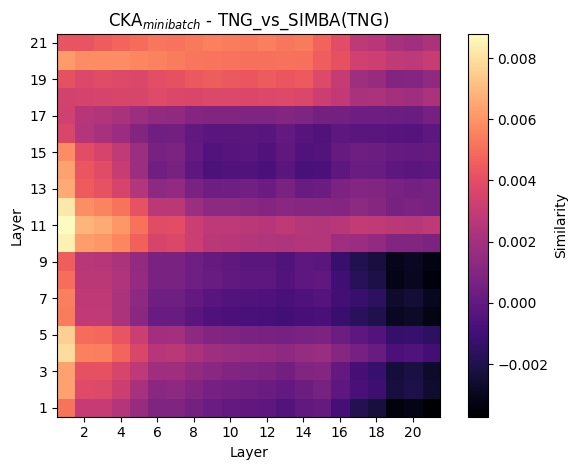

In [21]:
heatmap = across_cka.result().numpy()
plotHeatmap(heatmap, 'TNG_vs_SIMBA(TNG)') # accuracy 99.12%

## TNG + SIMBA

In [10]:
# load test set
fmaps = ['maps_T.npy']
test_loader1  = create_dataset_multifield('test', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                                         rot_flip_in_mem=False, verbose=True, simulation="TNG")

test_loader2  = create_dataset_multifield('test', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                                         rot_flip_in_mem=False, verbose=True, simulation="SIMBA")

TNG: 46
690
Found 1 channels
Reading data...
2.215e+02 < F(all|orig) < 2.772e+11
2.345 < F(all|resc)  < 11.443
-2.068 < F(all|norm) < 5.235
SIMBA: 54
810
Found 1 channels
Reading data...
2.215e+02 < F(all|orig) < 2.772e+11
2.345 < F(all|resc)  < 11.443
-2.068 < F(all|norm) < 5.235


In [11]:
test_data1 = []
test_data2 = []
for batch_idx, (data, _) in enumerate(test_loader1):
    test_data1.append(data)
for batch_idx, (data, _) in enumerate(test_loader2):
    test_data2.append(data)
# assert len(test_data1) == len(test_data2)

In [12]:
len(test_loader2)

7

In [15]:
model = model.to('cpu')
model.eval()

n_layers = 21
across_cka = MinibatchCKA(num_layers=n_layers, num_layers2=n_layers, across_models=True)
count = 0
iteration = 10
for i in tqdm(range(iteration)):
    for batch_idx in tqdm(range(5)):
        data1 = test_data1[batch_idx]
        data2 = test_data2[batch_idx]
        
        print(data1.shape)
        print(data2.shape)
        
        act1 = get_activations(data1, model, False)
        act2 = get_activations(data2, model, False)
        across_cka.update_state_across_models(act1, act2)
        
        count += len(data1)

print(count)

  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 20%|██        | 1/5 [00:13<00:53, 13.32s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 40%|████      | 2/5 [00:22<00:33, 11.05s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 60%|██████    | 3/5 [00:32<00:20, 10.40s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 80%|████████  | 4/5 [00:41<00:09,  9.99s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 20%|██        | 1/5 [00:09<00:36,  9.23s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 40%|████      | 2/5 [00:18<00:28,  9.38s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 60%|██████    | 3/5 [00:28<00:18,  9.41s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 80%|████████  | 4/5 [00:37<00:09,  9.32s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 20%|██        | 1/5 [00:09<00:37,  9.37s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 40%|████      | 2/5 [00:18<00:28,  9.40s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 60%|██████    | 3/5 [00:28<00:18,  9.40s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 80%|████████  | 4/5 [00:37<00:09,  9.40s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 20%|██        | 1/5 [00:09<00:37,  9.41s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 40%|████      | 2/5 [00:18<00:28,  9.35s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 60%|██████    | 3/5 [00:28<00:18,  9.35s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 80%|████████  | 4/5 [00:37<00:09,  9.41s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 20%|██        | 1/5 [00:09<00:36,  9.22s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 40%|████      | 2/5 [00:18<00:27,  9.31s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 60%|██████    | 3/5 [00:28<00:18,  9.36s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 80%|████████  | 4/5 [00:37<00:09,  9.35s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 20%|██        | 1/5 [00:09<00:37,  9.44s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 40%|████      | 2/5 [00:18<00:27,  9.27s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 60%|██████    | 3/5 [00:28<00:18,  9.35s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 80%|████████  | 4/5 [00:37<00:09,  9.32s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 20%|██        | 1/5 [00:09<00:37,  9.40s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 40%|████      | 2/5 [00:18<00:28,  9.37s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 60%|██████    | 3/5 [00:28<00:18,  9.34s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 80%|████████  | 4/5 [00:37<00:09,  9.34s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 20%|██        | 1/5 [00:09<00:37,  9.32s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 40%|████      | 2/5 [00:18<00:28,  9.34s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 60%|██████    | 3/5 [00:28<00:18,  9.37s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 80%|████████  | 4/5 [00:37<00:09,  9.33s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 20%|██        | 1/5 [00:09<00:37,  9.37s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 40%|████      | 2/5 [00:18<00:27,  9.26s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 60%|██████    | 3/5 [00:27<00:18,  9.27s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 80%|████████  | 4/5 [00:37<00:09,  9.32s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 20%|██        | 1/5 [00:09<00:38,  9.51s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 40%|████      | 2/5 [00:18<00:28,  9.38s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 60%|██████    | 3/5 [00:28<00:18,  9.36s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



 80%|████████  | 4/5 [00:37<00:09,  9.33s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])



100%|██████████| 10/10 [07:51<00:00, 47.19s/it]

6400


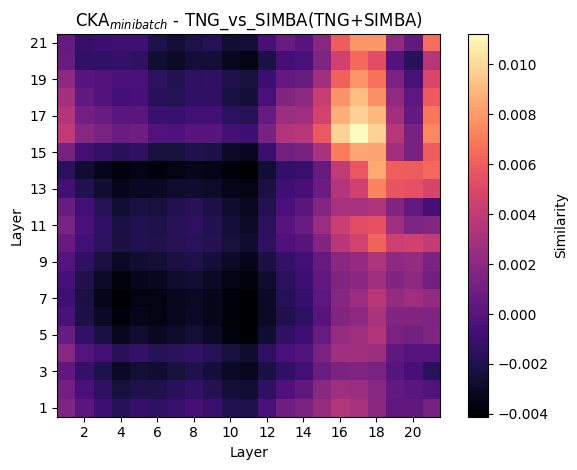

In [17]:
heatmap = across_cka.result().numpy()
plotHeatmap(heatmap, 'TNG_vs_SIMBA(TNG+SIMBA)') # accuracy 99.12%

## TNG vs TNG + SIMBA

In [23]:
# load test set
fmaps = ['maps_T_SIMBA.npy']
fparams = '2D_maps/data/params_LH_IllustrisTNG.txt'
test_loader1  = create_dataset_multifield('test', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                                         rot_flip_in_mem=False, verbose=True)


fmaps = ['maps_T.npy']
fparams = '2D_maps/data/params_LH.txt'
test_loader2  = create_dataset_multifield_new('test', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                                         rot_flip_in_mem=False, verbose=True, simulation="SIMBA")


750
Found 1 channels
Reading data...
2.215e+02 < F(all|orig) < 2.772e+11
2.345 < F(all|resc)  < 11.443
-2.708 < F(all|norm) < 4.815
SIMBA: 54
810
Found 1 channels
Reading data...
2.215e+02 < F(all|orig) < 2.772e+11
2.345 < F(all|resc)  < 11.443
-2.068 < F(all|norm) < 5.235


In [24]:
test_data1 = []
test_data2 = []
for batch_idx, (data, _) in enumerate(test_loader1):
    test_data1.append(data)
for batch_idx, (data, _) in enumerate(test_loader2):
    test_data2.append(data)
# assert len(test_data1) == len(test_data2)

In [25]:
# now that architecture is defined above, use it
model1 = model_o3_err(hidden, dr, channels)
# model = nn.DataParallel(model)
model1.to(device=device)
network_total_params = sum(p.numel() for p in model1.parameters())
print('total number of parameters in the model = %d'%network_total_params)

# load the weights in case they exists
# fmodel = 'layer17_TNG/weights.pt'
# fmodel = 'layer20_TNG_SIMBA/weights.pt'
fmodel = 'best_weights_T_TNG.pt'

if os.path.exists(fmodel):
    checkpoint = torch.load(fmodel, map_location=torch.device(device))
    new_state_dict = {k.replace('module.', ''): v for k, v in checkpoint.items()}
    model1.load_state_dict(new_state_dict)
    
    # model.load_state_dict(torch.load(fmodel, map_location=torch.device(device)))
    print('Weights loaded')
    
model1 = model1.to('cpu')
model1.eval()

total number of parameters in the model = 28436376
Weights loaded


model_o3_err(
  (C01): Conv2d(1, 22, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (C02): Conv2d(22, 22, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (C03): Conv2d(22, 22, kernel_size=(2, 2), stride=(2, 2), padding_mode=circular)
  (B01): BatchNorm2d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (B02): BatchNorm2d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (B03): BatchNorm2d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (C11): Conv2d(22, 44, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (C12): Conv2d(44, 44, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (C13): Conv2d(44, 44, kernel_size=(2, 2), stride=(2, 2), padding_mode=circular)
  (B11): BatchNorm2d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (B12): BatchNorm2d(44, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [26]:
# now that architecture is defined above, use it
model2 = model_o3_err_4(hidden, dr, channels)
# model = nn.DataParallel(model)
model2.to(device=device)
network_total_params = sum(p.numel() for p in model2.parameters())
print('total number of parameters in the model = %d'%network_total_params)

# load the weights in case they exists
# fmodel = 'layer17_TNG/weights.pt'
fmodel = 'layer20_TNG_SIMBA/weights.pt'
# fmodel = 'best_weights_T_TNG.pt'

if os.path.exists(fmodel):
    checkpoint = torch.load(fmodel, map_location=torch.device(device))
    new_state_dict = {k.replace('module.', ''): v for k, v in checkpoint.items()}
    model2.load_state_dict(new_state_dict)
    
    # model.load_state_dict(torch.load(fmodel, map_location=torch.device(device)))
    print('Weights loaded')
    
model2 = model2.to('cpu')
model2.eval()

total number of parameters in the model = 28430736
Weights loaded


model_o3_err_4(
  (C01): Conv2d(1, 22, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (C02): Conv2d(22, 22, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (C03): Conv2d(22, 22, kernel_size=(2, 2), stride=(2, 2), padding_mode=circular)
  (B01): BatchNorm2d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (B02): BatchNorm2d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (B03): BatchNorm2d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (C11): Conv2d(22, 44, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (C12): Conv2d(44, 44, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (C13): Conv2d(44, 44, kernel_size=(2, 2), stride=(2, 2), padding_mode=circular)
  (B11): BatchNorm2d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (B12): BatchNorm2d(44, eps=1e-05, momentum=0.1, affine=True, track_runn

In [27]:
n_layers = 21
across_cka = MinibatchCKA(num_layers=n_layers, num_layers2=n_layers, across_models=True)
count = 0
iteration = 10
for i in tqdm(range(iteration)):
    for batch_idx in tqdm(range(5)):
        data1 = test_data1[batch_idx]
        data2 = test_data2[batch_idx]
        
        print(data1.shape)
        print(data2.shape)
        
        act1 = get_activations(data1, model1, False)
        act2 = get_activations(data2, model2, False)
        across_cka.update_state_across_models(act1, act2)
        
        count += len(data1)

print(count)

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


 10%|█         | 1/10 [00:36<05:24, 36.01s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


 20%|██        | 2/10 [01:12<04:48, 36.03s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


 30%|███       | 3/10 [01:48<04:12, 36.07s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


 40%|████      | 4/10 [02:24<03:37, 36.17s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


 50%|█████     | 5/10 [03:00<03:01, 36.23s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


 60%|██████    | 6/10 [03:37<02:25, 36.26s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


 70%|███████   | 7/10 [04:13<01:48, 36.27s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


 80%|████████  | 8/10 [04:49<01:12, 36.33s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


 90%|█████████ | 9/10 [05:26<00:36, 36.31s/it]

torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


torch.Size([128, 1, 256, 256])
torch.Size([128, 1, 256, 256])


100%|██████████| 10/10 [06:02<00:00, 36.25s/it]

6400


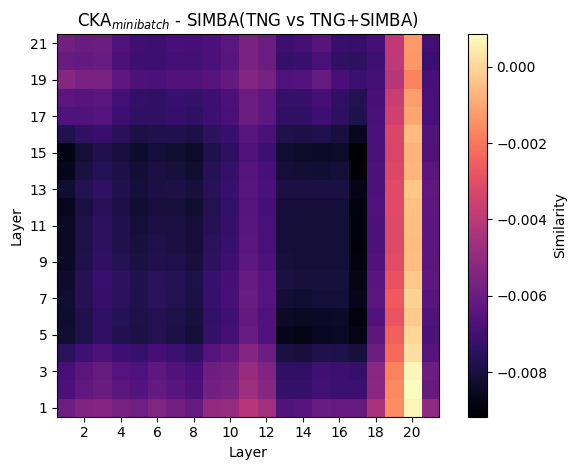

In [28]:
heatmap = across_cka.result().numpy()
plotHeatmap(heatmap, 'SIMBA(TNG vs TNG+SIMBA)') # accuracy 99.12%